In [1]:
import itertools
import gym
import torch
import torch.nn as nn

In [2]:
import _init_paths

add code root path (with `rllib`).


In [3]:
from rllib.actor_critic import ActorCritic
from rllib.misc import total_weights

In [4]:
env = gym.make("CartPole-v1")
action_n = env.action_space.n
observation_shape = env.observation_space.shape

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.affine1 = nn.Sequential(nn.Linear(observation_shape[0], 128),nn.ReLU())
        self.action_head = nn.Linear(128, action_n)
        self.value_head = nn.Linear(128, 1)

    def forward(self, x):
        x = self.affine1(x)
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return action_scores, state_values

net = Net()
print(net)
print("Model size:", total_weights(net))
agent = ActorCritic(model=net, gamma=0.99, learning_rate=1.e-3, batch_size=1)

Net(
  (affine1): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
  )
  (action_head): Linear(in_features=128, out_features=2, bias=True)
  (value_head): Linear(in_features=128, out_features=1, bias=True)
)
Model size: 1027


In [5]:
running_reward = 0

for episode in range(2000):
    obs = env.reset()
    total_reward = 0
    for step in itertools.count(start=1, step=1):
        action, log_prob, state_value = agent.select_action(obs)
        obs, reward, done, _ = env.step(action)
        agent.keep_for_grad(log_prob,state_value, reward)
        if step>=50000: # don't exceed
            print("Seems much but not enough")
            break
        if done:
             break
    agent.step() 
    
    total_reward, n_round, policy_loss, value_loss = agent.history[-1]
    
    count_gamma = 0.99
    running_reward = count_gamma*running_reward+(1-count_gamma)*total_reward
    print(episode, total_reward, running_reward)
    if running_reward>env.spec.reward_threshold:
        break
        
print("Finished: %s@%s" %(running_reward,episode))

0 12.0 0.1200000000000001
1 9.0 0.20880000000000018
2 13.0 0.3367120000000003
3 16.0 0.49334488000000043
4 11.0 0.5984114312000005
5 15.0 0.7424273168880007
6 16.0 0.8950030437191208
7 16.0 1.0460530132819297
8 15.0 1.1855924831491105
9 25.0 1.4237365583176196
10 20.0 1.6094991927344435
11 9.0 1.683404200807099
12 15.0 1.8165701587990282
13 12.0 1.918404457211038
14 46.0 2.359220412638928
15 35.0 2.685628208512539
16 16.0 2.818771926427414
17 17.0 2.96058420716314
18 23.0 3.160978365091508
19 14.0 3.269368581440593
20 30.0 3.5366748956261875
21 18.0 3.6813081466699256
22 20.0 3.8444950652032266
23 10.0 3.9060501145511943
24 11.0 3.9769896134056824
25 11.0 4.047219717271625
26 10.0 4.106747520098908
27 12.0 4.18568004489792
28 18.0 4.32382324444894
29 15.0 4.430585012004451
30 28.0 4.6662791618844075
31 22.0 4.8396163702655635
32 37.0 5.161220206562908
33 14.0 5.249608004497279
34 13.0 5.327111924452306
35 15.0 5.423840805207783
36 23.0 5.599602397155706
37 11.0 5.653606373184149
38 22.

In [6]:
torch.save(net.state_dict(), "actor_critic.pth")

In [7]:
for i in range(5):
    obs = env.reset()
    total_reward=0
    for _ in range(10000): # not exceed 10000 episodes
        action = agent.play(obs)
        obs, reward, done, _ = env.step(action)
        env.render()
        total_reward+=reward
        if done:
             break
    print("Encore: %s"%total_reward)

Encore: 500.0
Encore: 500.0
Encore: 500.0
Encore: 500.0
Encore: 500.0


In [8]:
import matplotlib.pyplot as plt

%matplotlib inline

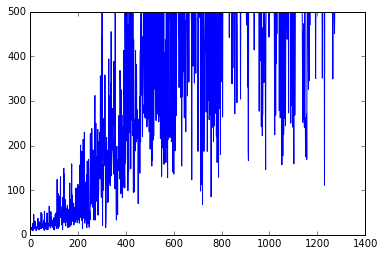

In [9]:
plt.plot([h[0] for h in agent.history])